In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
import numpy as np
import pickle
import cv2
from os import listdir
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import base64
import io

In [15]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = r"F:\New Dataset\archive\plantvillage dataset\color"
width=256
height=256
depth=3

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}\\{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}\\{plant_folder}\\{plant_disease_folder}")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}\\{plant_folder}\\{plant_disease_folder}\\{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bel

In [6]:
#Get Size of Processed Image
image_size = len(image_list)
print(image_size)

7552


In [7]:
#Transform Image Labels uisng Scikit Learn's LabelBinarizer
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
#Print the classes
print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [9]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [10]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [13]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [16]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/100
188/188 [==============================] - 60s 316ms/step - loss: 0.0575 - accuracy: 0.6349 - val_loss: 0.1100 - val_accuracy: 0.3766
Epoch 2/100
188/188 [==============================] - 59s 315ms/step - loss: 0.0507 - accuracy: 0.6915 - val_loss: 0.0931 - val_accuracy: 0.4408
Epoch 3/100
188/188 [==============================] - 59s 315ms/step - loss: 0.0474 - accuracy: 0.7133 - val_loss: 0.0937 - val_accuracy: 0.4600
Epoch 4/100
188/188 [==============================] - 59s 314ms/step - loss: 0.0421 - accuracy: 0.7462 - val_loss: 0.0488 - val_accuracy: 0.6850
Epoch 5/100
188/188 [==============================] - 59s 315ms/step - loss: 0.0422 - accuracy: 0.7504 - val_loss: 0.0690 - val_accuracy: 0.6248
Epoch 6/100
188/188 [==============================] - 59s 314ms/step - loss: 0.0402 - accuracy: 0.7605 - val_loss: 0.1004 - val_accuracy: 0.6320
Epoch 7/100
188/188 [==============================] - 59s 314ms/step - loss: 0.0358 - accuracy: 0.7898 - val_loss: 0.0480 -

Epoch 57/100
188/188 [==============================] - 59s 313ms/step - loss: 0.0068 - accuracy: 0.9762 - val_loss: 0.0358 - val_accuracy: 0.8398
Epoch 58/100
188/188 [==============================] - 59s 313ms/step - loss: 0.0073 - accuracy: 0.9714 - val_loss: 0.2132 - val_accuracy: 0.4957
Epoch 59/100
188/188 [==============================] - 59s 313ms/step - loss: 0.0072 - accuracy: 0.9722 - val_loss: 0.0226 - val_accuracy: 0.8987
Epoch 60/100
188/188 [==============================] - 59s 313ms/step - loss: 0.0073 - accuracy: 0.9684 - val_loss: 0.0336 - val_accuracy: 0.8557
Epoch 61/100
188/188 [==============================] - 59s 314ms/step - loss: 0.0063 - accuracy: 0.9777 - val_loss: 0.1813 - val_accuracy: 0.5063
Epoch 62/100
188/188 [==============================] - 59s 313ms/step - loss: 0.0062 - accuracy: 0.9744 - val_loss: 0.0183 - val_accuracy: 0.9140
Epoch 63/100
188/188 [==============================] - 59s 313ms/step - loss: 0.0062 - accuracy: 0.9764 - val_loss: 0

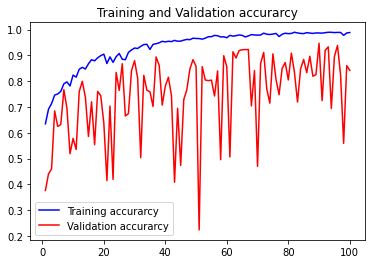

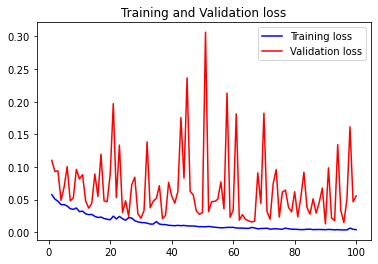

In [17]:
#Plot the train and val curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [18]:
#Model Accuracy
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
48/48 [==============================] - 1s 20ms/step - loss: 0.0555 - accuracy: 0.8418
Test Accuracy: 84.18266177177429


In [19]:
print("[INFO] Saving model...")

model.save('F:\Trained Models\\Color_84.h5')
print('Model Saved!')
 
# load model
savedModel=keras.models.load_model('F:\\Trained Models\\Color_84.h5')
print('Model Loaded')


[INFO] Saving model...
Model Saved!
Model Loaded


In [18]:
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [28]:
image_dir=r"F:\New Dataset\archive\plantvillage dataset\color\Plant Village\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot\0e0ed08d-3021-49a7-9098-7c90afeb2fd5___RS_GLSp 4346.JPG"

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [29]:
result = model.predict(npp_image)

print(result)

[[6.65371181e-17 3.43055032e-20 3.69354965e-21 1.11261810e-23
  5.95854893e-25 3.42337437e-27 1.43645820e-19 1.00000000e+00
  8.65852355e-12 3.30172382e-11 4.76210732e-18 2.22937191e-22
  4.10347520e-16 6.51150633e-20 6.23730129e-22 1.14102699e-20
  3.21844396e-18 1.02487767e-32 3.17046434e-21 2.49824163e-25
  1.40543988e-09 6.16018227e-25 1.29212955e-20 2.00234897e-22
  3.50459035e-16 3.86153635e-18 2.46783981e-15 8.30697607e-23
  2.59325998e-14 1.58109391e-18 3.78516052e-24 9.66682523e-22
  1.07270900e-10 6.81093418e-23 3.72114908e-17 1.24969037e-24
  2.64371933e-23 6.98317255e-17]]


In [30]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:1.0
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


Running Test with Images from Internet

In [31]:
savedModel=keras.models.load_model('F:\\Trained Models\\Color_84.h5')

In [35]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

savedModel.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [50]:
image_dir=r"F:\New Dataset\archive\plantvillage dataset\color\Plant Village\Strawberry___healthy\0b444634-b557-45f4-a68a-8e9e38cd6683___RS_HL 2184.JPG"
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [51]:
result = savedModel.predict(npp_image)

print(result)

[[8.31727262e-20 9.06385806e-20 1.47922402e-25 1.65246959e-15
  1.06676544e-05 1.02625100e-19 1.42774334e-12 8.85812498e-18
  5.06841454e-17 5.43733120e-22 1.62364772e-12 4.40086024e-25
  1.02971508e-05 8.01797458e-14 3.11036512e-15 1.41913753e-15
  1.76476209e-25 2.09698550e-26 2.33930878e-21 4.89259699e-09
  1.85767027e-11 2.85987057e-27 2.99981496e-14 7.27845315e-14
  7.24025284e-10 1.80016965e-14 2.59345395e-19 9.99978304e-01
  2.36645477e-25 4.40532593e-26 6.01439974e-22 1.05707163e-20
  3.07860980e-16 4.15273830e-23 7.37835930e-23 1.08934186e-20
  9.70194944e-26 7.63757782e-07]]


In [52]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.9999783
Strawberry___healthy
